In [0]:
!pip install tensorflow-gpu

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import tensorflow as tf
import pathlib
import random
import IPython.display as display
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import sklearn.metrics
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range
import glob
from keras.models import load_model
import tempfile
import zipfile

In [0]:
def get_all_paths(data_root):
    #This function allows us to get all image paths and randomly shuffles them.
    all_image_paths = list(data_root.glob('*/*'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)
    return all_image_paths

def get_path_and_label(data_root):
    #This function helps us get the path and label of each image.
    all_image_paths = get_all_paths(data_root)
    X = [p.rsplit('/', 2)[1] + '/' + p.rsplit('/', 1)[1] for p in all_image_paths]
    y = [p.rsplit('/', 1)[0].rsplit('/', 1)[1] for p in all_image_paths]
    return X, y
def caption_image(image_path):
    #This function helps us caption each image. 
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return image_rel, str(image_rel).split('/')[0]

def display_image_and_caption(data_root):
    #This function helps display the image. 
    for n in range(3):
        all_image_paths = get_all_paths(data_root)
        image_path = random.choice(all_image_paths)
        display.display(display.Image(image_path))
        imPath, label = caption_image(image_path)
        print(label)
        print()
def split_data(data_root, test_size, valid_size):
    #This function helps us split data into train, test and validation with ratio of 60:20:20
    X, y = get_path_and_label(data_root)
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=None)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, test_size=valid_size, stratify=y_train_temp, random_state=None)
    X_data = [X_train, X_test, X_valid]
    return X_data

def write_dataset_to_file(filenames, X_data, root_file):
    #This function writes all the datasets (train, test, validation) to files. 
    for d, l in zip(X_data, filenames):
        with open(root_file+l+'.txt', 'w') as f:
            for item in d:
                f.write("%s\n" % item)

def class_dictionary(data_root):
    ''' 
        This function make the class labels a dictionary as follows:
        {'recycle': 0, 'landfill': 1}
    '''
    all_image_paths = get_all_paths(data_root)
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
    label_to_index = dict((name, index) for index,name in enumerate(label_names))
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in all_image_paths]
    return label_to_index

def preprocess(image, h, w, is_training=False):
  #This function is for preprocessing images.
  image = tf.cast(image, tf.float32)
  image = image/255.
  image = tf.image.resize(image, (h, w))
 

  return image

# The following functions can be used to convert a value to a type compatible
# with tf.Example.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def image_example(image_string, label, filename):
    #This function Create a dictionary with features that may be relevant.
        
    image_shape = tf.image.decode_jpeg(image_string).shape
    for lab, val in label_to_index.items():    
        if lab == label:
            label_no = val
    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label_num': _int64_feature(label_no),
        'image_raw': _bytes_feature(image_string),
        'filename' : _bytes_feature(str.encode(filename)),
        'label': _bytes_feature(str.encode(label)),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(data_dir, split_path, output_path):
    #This function writes to tfrecords
    with tf.io.TFRecordWriter(output_path) as writer:
        f = open(split_path, "r")
        for line in f:
            label = line.split('/')[0]
            image_string = open(data_dir+line.rstrip('\n'), 'rb').read()
            tf_example = image_example(image_string, label, line)
            writer.write(tf_example.SerializeToString())

def create_image_feature_description():
    #This function create a dictionary describing the features.
    image_feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'label_num': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'filename' : tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    return image_feature_description

def parse_fn(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    image_feature_description = create_image_feature_description()
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_image(parsed["image_raw"], channels=3)
    image = tf.reshape(image, (parsed['height'], parsed['width'], 3))
    image = preprocess(image,299, 299, is_training=False)
    labs = tf.one_hot(parsed["label_num"], 2)
    return image, labs

def parse_fn_training(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    image_feature_description = create_image_feature_description()
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_image(parsed["image_raw"], channels=3)
    image = tf.reshape(image, (parsed['height'], parsed['width'], 3))
    #import pdb; pdb.set_trace()

    image = preprocess(image,299, 299, is_training=True)
    labs = tf.one_hot(parsed["label_num"], 2)
    return image, labs
  
def parse_fn_predict(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    image_feature_description = create_image_feature_description()
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_image(parsed["image_raw"], channels=3)
    image = tf.reshape(image, (parsed['height'], parsed['width'], 3))
    image = preprocess(image,299, 299, is_training=False)
    labs = tf.one_hot(parsed["label_num"], 2)
    filenames = parsed["filename"]
    return image, labs, filenames

def create_callbacks(log_dir, checkpoint_path):
    #This function creates model for logistic regression.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)
    early_stop_callback = tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-1,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=1,
        verbose=1)
    return tensorboard_callback, cp_callback, early_stop_callback

def make_dataset(datasetPath, shuffle_buffer_size, batch_size, is_training=True, is_predict=False):
    #This function makes dataset for each split data.
    dataset = tf.data.TFRecordDataset(datasetPath)
    if is_training:
      dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
      dataset = dataset.repeat()
      dataset = dataset.map(map_func=parse_fn_training)
    elif is_predict:
      dataset = dataset.map(map_func=parse_fn_predict)
    else:
      dataset = dataset.map(map_func=parse_fn)
    dataset = dataset.batch(batch_size=batch_size)
    return dataset
def evaluate_model(model ,model_path, dataset_eval, dataset_predict, steps, file_to_write):
  #This function evaluates the model.
  if(model):
    model.load_weights(model_path)

  else:
    model = load_model(model_path)

  loss, accuracy, precision, recall = model.evaluate(dataset_eval, steps=steps)
  
  predicted_classes = [] 

  for image, label, filename in dataset_predict:
    labels = np.argmax(label.numpy(), axis=1)
    classes = model.predict_classes(image)
    probabilities = model.predict_proba(image)
    for clas, fname, prob, actual in zip(classes, filename, probabilities, labels):
      for name, lab in label_to_index.items():    
        if lab == clas:
          predicted_label = name
        if lab == actual:
          actual_label = name
      predicted_classes.append(tuple((fname, actual_label, predicted_label, max(prob))))
            
  with open(file_to_write + 'predicted_classes_evaluate.txt', 'w') as fp:
    fp.write('\n'.join('%s %s %s %s' % x for x in predicted_classes))
        
  return accuracy, precision, recall
def make_prediction(ds_test_predict, te_steps_per_epoch, model, model_path, file_to_write_path):
  #This function makes the prediciton on new images.
  if(model):
    model.load_weights(model_path)

  else:
    model = load_model(model_path)

  files = [f for f in glob.glob(image_path + "**/*.jpg", recursive=True)]

  images = []
  filenames = []
  actual_labels = []

  for f in files:
    with tf.io.gfile.GFile(f, 'rb') as fopen:
        imge = fopen.read()
    imge = tf.image.decode_image(imge)
    w,h,d = imge.numpy().shape
    image = tf.reshape(imge, (w, h, d))
    image = preprocess(image,height, width, is_training=False)
    image = tf.expand_dims(image, 0)
    images.append(image)
    filenames.append(f.rsplit('/', 1)[1])

  images = np.vstack(images)
  classes = model.predict_classes(images)
  probabilities = model.predict_proba(images)
  print(classes, probabilities)
  predicted_classes = []
  for clas, fname, prob in zip(classes, filenames[3:], probabilities):
    for name, lab in label_to_index.items():    
      if lab == clas:
        predicted_classes.append(tuple((fname, name, max(prob))))

    with open(file_to_write_path + 'predicted_classes.txt', 'w') as fp:
      fp.write('\n'.join('%s %s %s' % x for x in predicted_classes))

    
  print(predicted_classes)
   

In [0]:
import cv2
import os
from pathlib import Path

def load_images_from_folder(data_root):
  images = []
  for filename in os.listdir(data_root):
      img = cv2.imread(os.path.join(data_root,filename))
      if img is not None:
        if img.shape[2] != 3 or len(img.shape) != 3:
          images.append(img.shape)
  #print(images) 

data_root = Path('/content/drive/My Drive/gc/gc1/')
label_to_index = class_dictionary(data_root)
folders = [*label_to_index]

for fol in folders:  
  load_images_from_folder('/content/drive/My Drive/gc/gc1/'+fol+'/')

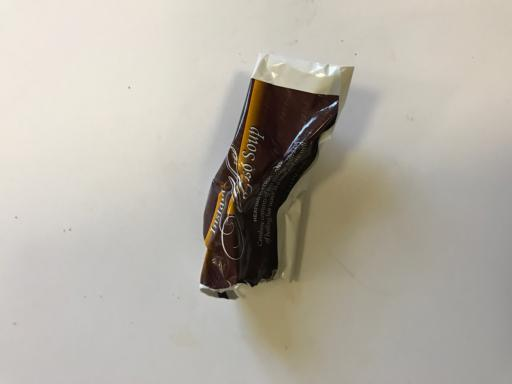

landfill



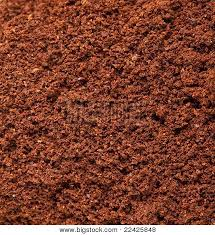

landfill



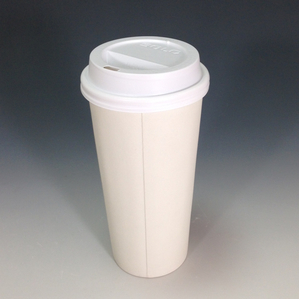

landfill



In [202]:
display_image_and_caption(data_root)

In [0]:
test_size = 0.20
valid_size = 0.20
X_data = split_data(data_root, test_size, valid_size)

In [204]:
label_to_index = class_dictionary(data_root)
print(label_to_index)

{'landfill': 0, 'recycle': 1}


In [0]:
filenames = ['trainData', 'testData', 'validataionData']
root_file = '/content/sample_data/ML/'
write_dataset_to_file(filenames, X_data, root_file)

In [0]:
data_dir = '/content/drive/My Drive/gc/gc1/'
write_tfrecords(data_dir, '/content/sample_data/ML/trainData.txt', '/content/sample_data/ML/trainImages.tfrecords') 
write_tfrecords(data_dir, '/content/sample_data/ML/validataionData.txt', '/content/sample_data/ML/testImages.tfrecords') 
write_tfrecords(data_dir, '/content/sample_data/ML/testData.txt', '/content/sample_data/ML/validImages.tfrecords')

In [0]:
shuffle_buffer_size = 1000
batch_size = 8
ds_train = make_dataset('/content/sample_data/ML/trainImages.tfrecords', shuffle_buffer_size, batch_size, is_training=True, is_predict=False)
ds_valid = make_dataset('/content/sample_data/ML/validImages.tfrecords', shuffle_buffer_size, batch_size, is_training=False, is_predict=False)
ds_test = make_dataset('/content/sample_data/ML/testImages.tfrecords', shuffle_buffer_size, 1, is_training=False, is_predict=False)
ds_test_predict = make_dataset('/content/sample_data/ML/testImages.tfrecords', shuffle_buffer_size, batch_size, is_training=False, is_predict=True)

In [0]:
num_train = len(X_data[0])
num_test = len(X_data[1])
num_val = len(X_data[2])
tr_steps_per_epoch = num_train//batch_size
val_steps_per_epoch = num_val//batch_size
te_steps_per_epoch = num_test//batch_size

In [0]:
IMG_SIZE = 299
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [0]:
for images, labels in ds_train.take(1):
    pass

print(images, labels)
feature_batch = base_model(images)

In [0]:
base_model.trainable = False

In [212]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 2048)


In [0]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [0]:
model = tf.keras.Sequential([base_model, global_average_layer, prediction_layer])

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [216]:
initial_epochs = 10
validation_steps = 20
log_dir="/content/sample_data/ML/models/feature_extraction/{}".format(time.strftime("%Y%m%d-%H%M%S"))
checkpoint_path = "/content/sample_data/ML/models/training/cp.ckpt/{}".format(time.strftime("%Y%m%d-%H%M%S"))
tensorboard_callback, cp_callback, early_stop_callback = create_callbacks(log_dir, checkpoint_path)
class_names = [*label_to_index]
history = model.fit(ds_train, epochs=initial_epochs, steps_per_epoch=tr_steps_per_epoch,validation_steps=val_steps_per_epoch, validation_data=ds_valid,callbacks=[tensorboard_callback, cp_callback, early_stop_callback])


Train for 235 steps, validate for 59 steps
Epoch 1/10
234/235 [============================>.] - ETA: 1s - loss: 0.6197 - accuracy: 0.6587 - precision_8: 0.6587 - recall_8: 0.6587
Epoch 00001: val_loss improved from inf to 0.47658, saving model to /content/sample_data/ML/models/training/cp.ckpt/20200118-220635
235/235 [==============================] - 570s 2s/step - loss: 0.6191 - accuracy: 0.6596 - precision_8: 0.6596 - recall_8: 0.6596 - val_loss: 0.4766 - val_accuracy: 0.7945 - val_precision_8: 0.7945 - val_recall_8: 0.7945
Epoch 2/10
234/235 [============================>.] - ETA: 1s - loss: 0.4378 - accuracy: 0.8494 - precision_8: 0.8494 - recall_8: 0.8494
Epoch 00002: val_loss improved from 0.47658 to 0.38097, saving model to /content/sample_data/ML/models/training/cp.ckpt/20200118-220635
235/235 [==============================] - 559s 2s/step - loss: 0.4387 - accuracy: 0.8489 - precision_8: 0.8489 - recall_8: 0.8489 - val_loss: 0.3810 - val_accuracy: 0.8729 - val_precision_8: 0

In [217]:
dataset_predict = ds_test_predict
dataset_eval = ds_test
steps = te_steps_per_epoch
file_to_write = '/content/sample_data/ML/'
model_path = checkpoint_path
accuracy, precision, recall = evaluate_model(model, model_path, dataset_eval, dataset_predict, steps, file_to_write)

print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))

73/73 [==============================] - 18s 247ms/step - loss: 0.5134 - accuracy: 0.8356 - precision_8: 0.8356 - recall_8: 0.8356
Accuracy: 0.8356164
Precision: 0.8356164
Recall: 0.8356164


In [0]:
model.save('/content/sample_data/ML/my_model.h5')

In [218]:
_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

Saving model to:  /tmp/tmpc8u8ll6d.h5


In [0]:
tflite_model_file = '/tmp/inception_float.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_model_file, 'wb') as f:
  f.write(tflite_model)

In [230]:
tflite_interpreter = tf.lite.Interpreter(model_path=tflite_model_file)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

# Print images batch and labels predictions
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

== Input details ==
shape: [  1 299 299   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [1 2]
type: <class 'numpy.float32'>


In [229]:
image_path = '/content/drive/My Drive/gc/gc1/landfill/'
file_to_write_path = '/content/sample_data/ML/'
# classes = model.predict_classes(image_path)
# probabilities = model.predict_proba(image_path) 
height = 299
width = 299
model_path = checkpoint_path
make_prediction(ds_test_predict,te_steps_per_epoch, model, model_path, file_to_write_path)

[0 0 0 ... 0 0 0] [[0.9267546  0.07324547]
 [0.82973504 0.17026491]
 [0.92159444 0.07840551]
 ...
 [0.8767018  0.12329817]
 [0.74392074 0.2560793 ]
 [0.7511401  0.24885993]]
[('O_9.jpg', 'landfill', 0.9267546), ('O_13555.jpg', 'landfill', 0.82973504), ('O_243.jpg', 'landfill', 0.92159444), ('O_257.jpg', 'recycle', 0.6683529), ('trash124.jpg', 'landfill', 0.7467977), ('trash130.jpg', 'landfill', 0.7167721), ('O_8007.jpg', 'landfill', 0.70332825), ('O_8013.jpg', 'recycle', 0.9572127), ('trash118.jpg', 'recycle', 0.85530823), ('O_13838.jpg', 'landfill', 0.70986164), ('O_99.jpg', 'landfill', 0.72641104), ('O_7888.jpg', 'recycle', 0.7311811), ('trash12.jpg', 'landfill', 0.8594462), ('O_13810.jpg', 'landfill', 0.5148455), ('O_66.jpg', 'landfill', 0.83468074), ('O_13804.jpg', 'recycle', 0.8955369), ('O_7863.jpg', 'landfill', 0.78053963), ('O_13623.jpg', 'landfill', 0.65552294), ('O_7877.jpg', 'landfill', 0.8105577), ('O_13637.jpg', 'landfill', 0.8277673), ('O_72.jpg', 'landfill', 0.5767033), 